## Imports

In [76]:
import numpy as np
import random
import statistics
from statistics import median
import matplotlib.pyplot as plt # Para graficar la distribución
from scipy import stats
import pywt
from fbm import FBM



## Funciones necesarias

### pdfcdfcontinua

In [77]:
def pdfcdfcontinua(datos, minimo=None, maximo=None, particiones=None):
    """
    Estima la función de densidad (PDF) y la función de distribución acumulativa (CDF)
    de una muestra aleatoria `datos` usando histogramas.
    """

    datos = np.ravel(datos)
    total = len(datos)

    if minimo is None or maximo is None:
        rango = np.max(datos) - np.min(datos)
        minimo = np.min(datos) - 0.02 * rango
        maximo = np.max(datos) + 0.02 * rango

    print(minimo, maximo)

    if particiones is None:
        particiones = int(np.floor(np.sqrt(total)))

    bins = np.linspace(minimo, maximo, particiones + 1)

    # Histograma normalizado (densidad=True) para obtener PDF
    fr, edges = np.histogram(datos, bins=bins, density=False)
    ancho_bin = edges[1] - edges[0]
    pdf = fr / (total * ancho_bin)

    # CDF como suma acumulativa de las frecuencias normalizadas
    cdf = np.cumsum(fr) / total

    x = edges[:-1] + ancho_bin / 2  # Coordenadas del centro de cada bin

    # Gráficas
    fig, axs = plt.subplots(2, 1, figsize=(8, 6))

    axs[0].plot(x, pdf, linewidth=2)
    axs[0].set_title("Estimación de la función de densidad")
    axs[0].set_xlabel("$x$")
    axs[0].set_ylabel("$f_X(x)$")
    axs[0].grid(True)

    axs[1].plot(x, cdf, linewidth=2)
    axs[1].set_title("Estimación de la Distribución Acumulativa")
    axs[1].set_xlabel("$x$")
    axs[1].set_ylabel("$F_X(x)$")
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

### superfuncion

In [78]:
def superfuncion(datos, nombre='aleatorio'):
    if datos is None or len(datos) == 0:
        print("Falta el vector de datos")
        return

    p = np.linspace(0, 1, 100000)
    datos = 1.0000000001 * np.array(datos).flatten()
    numero = np.quantile(datos, p)

    encabezado = f"def {nombre}(m, n):"
    cuerpo = f"    numero = {numero.tolist()}"
    final = (
        "    import numpy as np\n"
        "    if m == 1:\n"
        "        return np.transpose(np.random.choice(numero, (n,)))\n"
        "    else:\n"
        "        return np.random.choice(numero, (m, n))"
    )

    with open(f"{nombre}.py", "w") as f:
        f.write(encabezado + "\n")
        f.write(cuerpo + "\n")
        f.write(final + "\n")

    print(f"{nombre}.py generado. Revisa tu carpeta actual.")
    print(f"Luego puedes ejecutar: from {nombre} import {nombre}; {nombre}(m,n)")

In [79]:
# BCpAug89
datosAug = np.loadtxt("./BCpAug89.TL")
muestraAgosto = np.diff(datosAug[:, 1])

# BCpOct89
datosOct = np.loadtxt("./BCpOct89.TL")
muestraOctubre = np.diff(datosOct[:, 0])

# BCOct89Ext
datosOctExt = np.loadtxt("./BCOct89Ext.TL")
muestraOctubreExt = np.diff(datosOctExt[:, 0])

# BCOct89Ext4
datosOctExt4 = np.loadtxt("./BCOct89Ext4.TL")
muestraOctubreExt4 = np.diff(datosOctExt4[:, 0])

In [80]:
superfuncion(muestraAgosto, "agostoAleatorio")
superfuncion(muestraOctubreExt4, "octubreExt4Aleatorio")

agostoAleatorio.py generado. Revisa tu carpeta actual.
Luego puedes ejecutar: from agostoAleatorio import agostoAleatorio; agostoAleatorio(m,n)
octubreExt4Aleatorio.py generado. Revisa tu carpeta actual.
Luego puedes ejecutar: from octubreExt4Aleatorio import octubreExt4Aleatorio; octubreExt4Aleatorio(m,n)


In [81]:
import agostoAleatorio
import octubreExt4Aleatorio

In [82]:
muestraAgostosf = agostoAleatorio.agostoAleatorio(1, 1000000)
muestraAgostosf

array([  -96.00000001,   108.00000001,     0.        , ...,
         -12.        , -1018.0000001 ,    12.        ])

In [83]:
muestraOctubreExt4sf = octubreExt4Aleatorio.octubreExt4Aleatorio(1, 1000000)
muestraOctubreExt4sf

array([0.001748  , 0.007756  , 0.014596  , ..., 1.39581441, 0.011104  ,
       0.003168  ])

### vt

In [136]:

def _pendienteci(x, y):
    """
    Regresión lineal simple (mínimos cuadrados) y cálculo de intervalo de confianza al 95% para la pendiente.

    Parámetros
    ----------
    x : 1D array
        Variable independiente (log10(m)).
    y : 1D array
        Variable dependiente (log10(varianza)).

    Devuelve
    -------
    m : float
        Pendiente de la recta.
    b : float
        Ordenada al origen de la recta.
    ml : float
        Límite inferior de intervalo de confianza (95%) para m.
    mh : float
        Límite superior de intervalo de confianza (95%) para m.
    """
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    n = x.size
    if n < 3:
        raise ValueError("Se requieren al menos 3 puntos para realizar regresión.")

    # Cálculo de parámetros de la recta: m y b
    A = np.dot(x, x)
    B = x.sum()
    C = np.dot(x, y)

    x_mean = x.mean()
    y_mean = y.mean()

    m = (C - B * y_mean) / (A - B * x_mean)
    b = y_mean - m * x_mean

    # Error residual
    y_pred = m * x + b
    error = y - y_pred
    s = np.sqrt(np.dot(error, error) / (n - 2))

    # Sxx = sum((x - x_mean)^2)
    ex = x - x_mean
    Sxx = np.dot(ex, ex)

    # t critico para 95% en n-2 grados de libertad
    tval = stats.t.ppf(0.975, df=n - 2)

    # Intervalo de confianza para la pendiente m
    ml = m - tval * s / np.sqrt(Sxx)
    mh = m + tval * s / np.sqrt(Sxx)

    return m, b, ml, mh

def vt(traza, plot = False):
    """
    Diagrama Varianza–Tiempo y estimación del parámetro de Hurst.

    Parámetros
    ----------
    traza : array_like, 1D
        Vector de datos (serie de tiempo) sobre el cual se calcula el diagrama varianza–tiempo.

    Devuelve
    -------
    H     : float
        Estimación del parámetro de Hurst (punto medio de la recta).
    Hmin  : float
        Límite inferior del intervalo de confianza al 95% para H.
    Hmax  : float
        Límite superior del intervalo de confianza al 95% para H.

    Además, la función dibuja (en pantalla) el diagrama log10(varianza) vs. log10(m)
    junto con la recta de regresión lineal y su intervalo de confianza.
    """
    traza = np.asarray(traza).flatten()
    L = traza.size

    # gruposmax = fix(L / sqrt(L)) en MATLAB equivale a floor(sqrt(L))
    gruposmax = int(np.floor(np.sqrt(L)))
    if gruposmax < 2:
        raise ValueError("La longitud de 'traza' es demasiado pequeña para calcular vt().")

    # Reservamos un arreglo para varianza; tendrá longitud (gruposmax - 1)
    varianza = np.zeros(gruposmax - 1, dtype=float)

    # Para cada n = 2 ... gruposmax, calculamos:
    #   columnas = fix(L / n)
    #   datos  = reshape(traza(1 : n*columnas), [n, columnas])
    #   varianza(n-1) = var(promedios), donde promedios = mean(datos) (promedio por columna)
    for idx, n in enumerate(range(2, gruposmax + 1)):
        columnas = int(np.floor(L / n))
        if columnas < 1:
            # si columnas=0, no podemos reshape; salir del bucle
            break

        # Reproducimos reshape(..., [n, columnas]) de MATLAB (que rellena por columnas).
        bloque = traza[: n * columnas]
        datos = bloque.reshape((n, columnas), order='F')

        # promedio de cada columna (dim=0) y varianza muestral (ddof=1)
        promedios = datos.mean(axis=0)
        varianza[idx] = np.var(promedios, ddof=1)

    # Tomamos sólo los índices válidos (en caso de que el bucle se haya roto antes)
    Npts = idx + 1
    varianza = varianza[:Npts]

    # Construimos x = log10(m) para m = 2,3,...,2+Npts-1
    m_vals = np.arange(2, 2 + Npts)
    x = np.log10(m_vals)
    y = np.log10(varianza)

    # Regresión lineal con intervalo de confianza
    m_slope, b_intercept, ml, mh = _pendienteci(x, y)

    H     = m_slope / 2 + 1
    Hmin  = ml / 2 + 1
    Hmax  = mh / 2 + 1

    # --- Visualización del diagrama ---
    if plot:
        fig, ax = plt.subplots(figsize=(8, 5))
        # Puntos experimentales
        ax.plot(x, y, 's', markerfacecolor='b', markeredgecolor='k', label=r'$\log S_{X^{(m)}}^2$')

        # Recta de regresión: y_hat = m_slope * x + b_intercept
        y_hat = m_slope * x + b_intercept
        ax.plot(x, y_hat, 'r', linewidth=2, label='Regresión Lineal')

        # Intervalo de confianza (líneas punteadas)
        xmin, xmax = x.min(), x.max()
        ymin, ymax = y.min(), y.max()

        # Definimos x1, x2 tal como en MATLAB (0.45 y 0.55 del rango)
        x1 = xmin + 0.45 * (xmax - xmin)
        x2 = xmin + 0.55 * (xmax - xmin)
        y1 = m_slope * x1 + b_intercept
        y2 = m_slope * x2 + b_intercept

        # Dibujamos: una línea vertical en x = x1 desde y1 hasta y2, y luego la horizontal en y = y2 de x1 a x2
        ax.plot([x1, x1, x2], [y1, y2, y2], 'k:', linewidth=2)

        # Ajustes estéticos
        ax.set_title('Diagrama Varianza - Tiempo', fontsize=18)
        ax.set_xlabel(r'$\log m$', fontsize=18)
        ax.set_ylabel(r'$\log S_{X^{(m)}}^2$', fontsize=18)
        ax.grid(True)
        ax.set_xlim(xmin, xmax)
        delta_y = ymax - ymin
        ax.set_ylim(ymin - 0.1 * delta_y, ymax + 0.1 * delta_y)
        ax.tick_params(labelsize=16)
        ax.legend(loc='best', fontsize=14, frameon=False)
        fig.patch.set_facecolor('white')

        plt.show()

    return H, Hmin, Hmax



### ld

In [157]:
def LD(traza, plot = False):
    """
    Diagrama Log–Escala (LD) vía transformada wavelet de Haar.

    Parámetros
    ----------
    traza : array_like, 1D
        Serie de datos (vector) de entrada.

    Devuelve
    -------
    H     : float
        Estimación del parámetro de Hurst (punto medio).
    alpha : float
        Pendiente de la regresión lineal en el diagrama log–escala.

    Además, la función dibuja el diagrama log–escala y la recta de regresión
    entre las octavas j1=2 y j2=N-1 (donde N = floor(log2(len(traza))/2 + 1)).
    """
    # Convertir a 1D de NumPy
    X = np.asarray(traza).flatten()
    L = X.size

    # Parámetros por defecto (versión 2.0)
    wavelet = 'db1'  # Haar
    j1 = 2
    N = int(np.floor(np.log2(L) / 2 + 1))  # floor(log2(length)/2 + 1)
    j2 = N - 1

    # Descomposición wavelet de nivel N
    # coeffs = [cA_N, cD_N, cD_{N-1}, ..., cD_1]
    coeffs = pywt.wavedec(X, wavelet, level=N)

    # Construir vector mu de tamaño N. Sólo usaremos índices 1..N-1
    mu = np.zeros(N, dtype=float)

    # Para i = 1 .. N-1, extraer detalle D_i y calcular mu[i] = mean(abs(D_i)^2)
    #   En pywt, el detalle a nivel i está en coeffs[-i].
    for i in range(1, N):
        D_i = coeffs[-i]
        mu[i] = np.mean(np.abs(D_i)**2)

    # Construir los vectores para graficar:
    #   j_all = 1,2,...,N-1   (longitud N-1)
    #   y_all = log2(mu[1]), log2(mu[2]), ..., log2(mu[N-1])
    j_all = np.arange(1, N)
    y_all = np.log2(mu[1:N])

    # Ajuste lineal (Mínimos Cuadrados) sobre j = j1 .. j2
    js = np.arange(j1, j2 + 1)               # [2, 3, ..., N-1]
    y_vals = np.log2(mu[j1:j2 + 1])          # log2(mu_j) para j=j1..j2

    coef = np.polyfit(js, y_vals, 1)
    alpha = coef[0]
    intercept = coef[1]

    # Cálculo de Hurst
    H = alpha / 2 + 0.5

    # Cálculo de intervalo de confianza para H (95%)
    j = j2 - j1
    nj1 = coeffs[-j1].size

    numer = 2 * (1 - 2**(-j))
    denom = nj1 * (np.log(2)**2) * (1 - 2**(-(j + 1)) * (j**2 + 4) + 2**(-2 * j))
    desviacion = np.sqrt(numer / denom)
    error = 1.9599 * desviacion  # t ≈ 1.96 para 95%

    Hmin = H - error
    Hmax = H + error

    # --- Gráfica del diagrama log–escala ---
    if plot:
        plt.figure(figsize=(8, 5))

        # Puntos experimentales: (j_all, y_all)
        plt.plot(j_all, y_all, 'b.', label=r'$\log_2(\mu_j)$')

        # Recta de regresión sólo sobre el tramo j1..j2
        #   Pero podemos extenderla para que cubra todo j_all.
        x_line = np.array([j_all.min(), j_all.max()])
        y_line = intercept + alpha * x_line
        plt.plot(x_line, y_line, 'r-', linewidth=2, label='Regresión Lineal')

        # Ajustes estéticos
        plt.title('Diagrama Log–Escala (LD)', fontsize=18)
        plt.xlabel(r'Octava $j$', fontsize=16)
        plt.ylabel(r'$y_j = \log_2(\mu_j)$', fontsize=16)
        plt.grid(True)
        plt.tick_params(labelsize=14)
        plt.legend([
            fr'Estimación: $H = {H:.4f}$',
            fr'IC 95\%: {Hmin:.4f} < H < {Hmax:.4f}'
        ], fontsize=12, loc='best')
        plt.gcf().patch.set_facecolor('white')
        plt.tight_layout()
        plt.show()

    return H, alpha


### betamwm

In [87]:
import numpy as np

def betamwm(Uoo, n, H, seed=None):
    """
    Versión universal de betamwm que admite Uoo escalar o vector.

    Parámetros:
    -----------
    Uoo : float o array_like
        Valor inicial (escalar) o vector (1D).
    n : int
        Número de iteraciones.
    H : float
        Exponente de Hurst (0 < H < 1).
    seed : int o None
        Semilla opcional para reproducibilidad.

    Retorna:
    --------
    traza : ndarray de longitud len(Uoo)*(2**n)
        Array 1D con la “traza” final después de n iteraciones.
    """
    if seed is not None:
        np.random.seed(seed)

    # Asegurarnos de que traza sea array 1D
    traza = np.array(Uoo, dtype=float).flatten()

    beta = (2**(2*H - 1) - 1) / (2 - 2**(2*H - 1))

    for i in range(1, n+1):
        # Antes de duplicar, traza tiene cierta longitud actual (m_old)
        m_old = traza.size

        # Generar m_old muestras Beta. Cada una genera dos valores en p.
        b = np.random.beta(beta, beta, size=m_old)

        # Ahora p de longitud 2*m_old = [b₁, 1-b₁, b₂, 1-b₂, …]
        p = np.empty(2 * m_old, dtype=float)
        p[0::2] = b
        p[1::2] = 1 - b

        # Duplicar cada valor de traza: [t1,t2,…] -> [t1,t1,t2,t2,…]
        traza = np.repeat(traza, 2)

        # Multiplicar elemento a elemento
        traza = traza * p

    return traza


### Analisis multifractal

In [88]:
def compute_dwt_coeffs(x, wavelet='db1', max_level=None):
    """
    Calcula la DWT en 1D de la señal x hasta el nivel máximo posible (o indicado).
    Retorna:
      - coeffs: lista [cA_n, cD_n, cD_{n-1}, ..., cD_1]
      - n_levels: número de niveles efectivos
    """
    if max_level is None:
        max_level = pywt.dwt_max_level(len(x), pywt.Wavelet(wavelet).dec_len)
    coeffs = pywt.wavedec(x, wavelet, level=max_level)
    return coeffs, max_level

def compute_wavelet_leaders(coeffs):
    """
    A partir de coeffs = [cA_n, cD_n, cD_{n-1}, ..., cD_1],
    construye los Wavelet Leaders L[j][k] para cada escala j=1..n.
    Retorna una lista Leaders de longitud (n_levels+1), donde Leaders[j]
    es un array de tamaño igual a len(cD_j).
    """
    n = len(coeffs) - 1  # número de niveles detalle
    # Reordenar coeficientes de detalle en un array d[j]
    d = [None] * (n + 1)
    for i in range(1, n + 1):
        j = n - i + 1
        d[j] = coeffs[i].copy()

    # Inicializar Leaders[j] con zeros
    Leaders = [None] * (n + 1)
    for j in range(1, n + 1):
        Leaders[j] = np.zeros(len(d[j]), dtype=float)

    # Calcular el supremo de |d[i,m]| para i>=j y m en vecindad de k
    for j in range(1, n + 1):
        mj = len(d[j])
        for k in range(mj):
            # Tomar coeficientes de detalle en la misma escala j (posición k y vecinos)
            max_val = 0.0
            for kk in (k - 1, k, k + 1):
                if 0 <= kk < mj:
                    v = abs(d[j][kk])
                    if v > max_val:
                        max_val = v

            # Ahora, para cada i > j, considerar la posición correspondiente
            for i in range(j + 1, n + 1):
                mi = len(d[i])
                # Relación aproximada de índices: m ≈ k * (mi / mj)
                approx_pos = int(np.floor(k * mi / mj))
                for m in (approx_pos - 1, approx_pos, approx_pos + 1):
                    if 0 <= m < mi:
                        v = abs(d[i][m])
                        if v > max_val:
                            max_val = v

            Leaders[j][k] = max_val

    return Leaders

def estimate_tau_q_and_cp(Leaders, q_list):
    """
    Dado Leaders[j][k] para j=1..n, calcula para cada q en q_list:
      - tau(q) ajustando log2 S(q,j) vs j,
      - y devuelve también cp = S(q,j) para cada j.
    cp será un array de forma (len(q_list), n_levels), donde:
       cp[i,q] = S(q, j) en la escala j = i+1.
    """
    n = len(Leaders) - 1
    js = np.arange(1, n + 1)
    nq = len(q_list)

    taus = np.zeros(nq, dtype=float)
    # cp[i, j-1] = S(q_i, j)
    cp = np.zeros((nq, n), dtype=float)

    for iq, q in enumerate(q_list):
        S_qj = np.zeros(n, dtype=float)
        for j in range(1, n + 1):
            S_qj[j - 1] = np.sum(Leaders[j] ** q)

        cp[iq, :] = S_qj

        # Ajustar regresión lineal en base 2: log2(S_qj) = -tau(q)*j + const
        log2_S = np.log2(S_qj + 1e-16)  # evitar log(0)
        slope, intercept, r, p, stderr = stats.linregress(js, log2_S)
        taus[iq] = -slope

    return taus, cp

def legendre_spectrum(taus, q_list):
    """
    Aplica la transformada de Legendre para convertir tau(q) en (h, D(h)):
      h(q) = d tau(q) / d q,
      D(h(q)) = q * h(q) - tau(q).
    La derivada se aproxima con diferencias finitas centradas.
    Retorna:
      - h_vals: array de tamaño len(q_list)
      - D_vals: array de tamaño len(q_list)
    """
    nq = len(q_list)
    h_vals = np.zeros(nq, dtype=float)
    dq = q_list[1] - q_list[0]

    for i in range(nq):
        if i == 0:
            h_vals[i] = (taus[i + 1] - taus[i]) / dq
        elif i == nq - 1:
            h_vals[i] = (taus[i] - taus[i - 1]) / dq
        else:
            h_vals[i] = (taus[i + 1] - taus[i - 1]) / (2 * dq)

    D_vals = q_list * h_vals - taus
    return h_vals, D_vals

def dwtleader_py(x, q_list=None, wavelet='db1'):
    """
    Repliega en 1 función el cálculo completo tipo MATLAB dwtleader:
      Input:
        - x: array 1D (por ejemplo, la 'muestra' = datos[:,2]')
        - q_list: vector de valores q. Si None, se usa np.arange(-5,6).
        - wavelet: cadena, p.ej. 'db1'.

      Output:
        - tauq: array con tau(q) para cada q en q_list
        - h_vals: array con h(q)
        - D_vals: array con D(h(q))
        - cp: array de forma (len(q_list), n_levels) con S(q,j)

    Nota: la escala j va de 1 a n_levels, donde n_levels ~ floor(log2(len(x))).
    """
    x = np.asarray(x).flatten()

    if q_list is None:
        q_list = np.arange(-5, 6)  # [-5, -4, ..., 5]

    # 1) Calcular DWT
    coeffs, n_levels = compute_dwt_coeffs(x, wavelet=wavelet, max_level=None)

    # 2) Calcular Wavelet Leaders
    Leaders = compute_wavelet_leaders(coeffs)

    # 3) Calcular tau(q) y cp = S(q,j)
    tauq, cp = estimate_tau_q_and_cp(Leaders, q_list)

    # 4) Transformada de Legendre para (h, D(h))
    h_vals, D_vals = legendre_spectrum(tauq, q_list)

    return tauq, h_vals, D_vals, cp


# Actividad 1

## Prueba de sesgo

## Prueba de robustez

## Prueba de sesgo

In [ ]:
# Parámetros de la distribución uniforme discreta
valor_minimo = 1
valor_maximo = 6
numero_de_muestras = 100
muestras = np.random.randint(valor_minimo, valor_maximo + 1, size=numero_de_muestras)

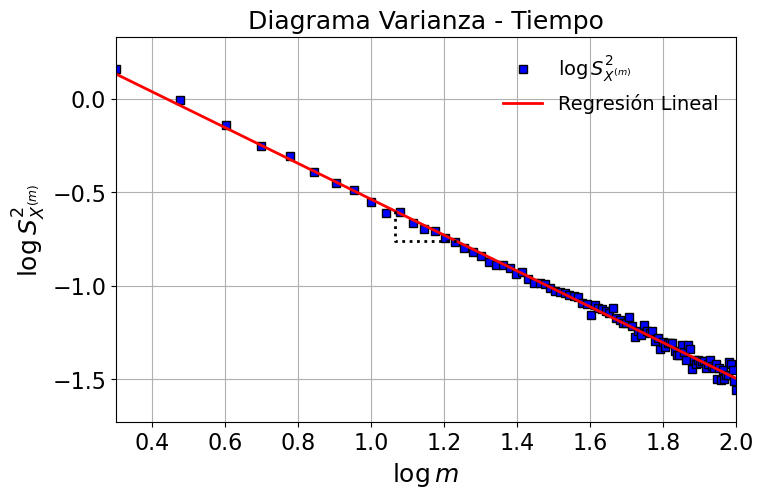

0.520882156301675


In [ ]:
h, hmin, hmax =  vt(muestras)
print(h)

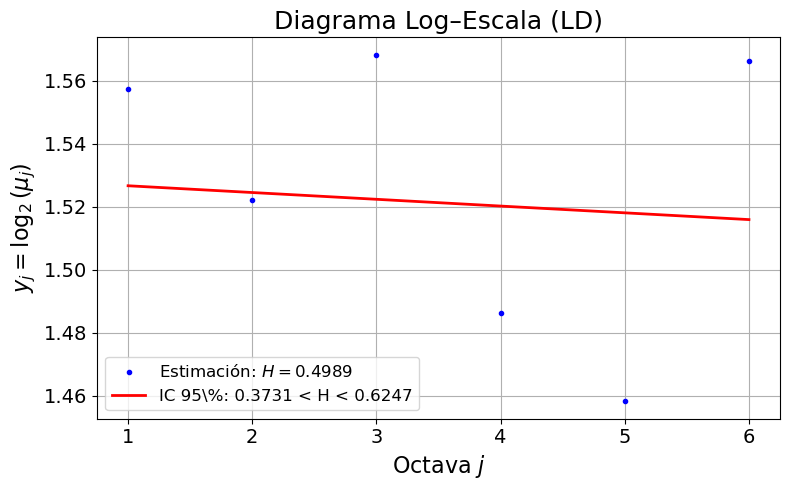

0.4989264819419052


In [100]:
hld, alpha = LD(muestras)
print(hld)

In [64]:
print(f"Algunas muestras generadas (primeras 20): {muestras[:20]}")
print(f"Valor mínimo generado: {np.min(muestras)}")
print(f"Valor máximo generado: {np.max(muestras)}")

Algunas muestras generadas (primeras 20): [1 3 1 4 3 2 4 5 2 5 2 2 5 4 3 6 4 4 1 4]
Valor mínimo generado: 1
Valor máximo generado: 6


In [65]:
# Calcular la frecuencia de cada número
valores_unicos, conteos = np.unique(muestras, return_counts=True)
for valor, conteo in zip(valores_unicos, conteos):
    print(f"Valor: {valor}, Frecuencia: {conteo}, Probabilidad estimada: {conteo/numero_de_muestras:.4f}")

Valor: 1, Frecuencia: 1709, Probabilidad estimada: 0.1709
Valor: 2, Frecuencia: 1649, Probabilidad estimada: 0.1649
Valor: 3, Frecuencia: 1688, Probabilidad estimada: 0.1688
Valor: 4, Frecuencia: 1686, Probabilidad estimada: 0.1686
Valor: 5, Frecuencia: 1585, Probabilidad estimada: 0.1585
Valor: 6, Frecuencia: 1683, Probabilidad estimada: 0.1683


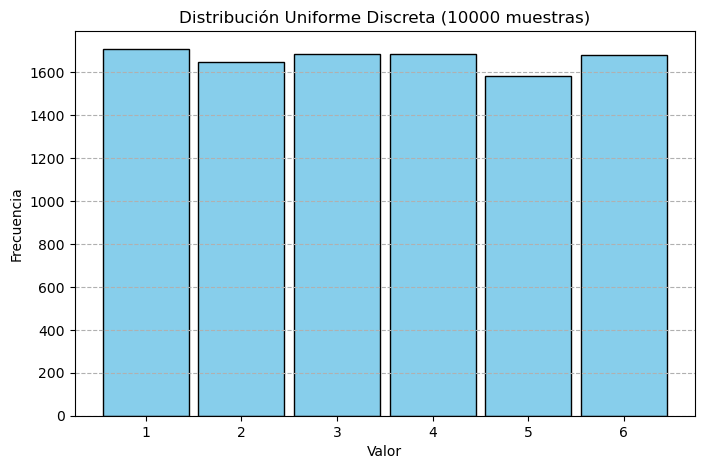

In [66]:
# Graficar el histograma de las muestras para visualizar la distribución
plt.figure(figsize=(8, 5))
plt.bar(valores_unicos, conteos, width=0.9, color='skyblue', edgecolor='black')
plt.xlabel("Valor")
plt.ylabel("Frecuencia")
plt.title(f"Distribución Uniforme Discreta ({numero_de_muestras} muestras)")
plt.xticks(range(valor_minimo, valor_maximo + 1)) # Asegurar que todos los valores del rango aparezcan en el eje x
plt.grid(axis='y', linestyle='--')
plt.show()

In [180]:
num_subconjuntos = 100000# este parametro es determinante del número de subconjuntos que se generarán
# Calcular el tamaño de cada subconjunto como la división entera del total de muestras
# si el número total de muestras no es divisible por num_subconjuntos, se redondeará hacia abajo
#tamaños_subconjuntos = [100, 500, 1000, 2000]  # Tamaños de subconjuntos a considerar
#tamaño_subconjunto = numero_de_muestras // num_subconjuntos
#tamaños_subconjuntos = [tamaño_subconjunto * i for i in range(1, num_subconjuntos + 1)]
#tamaños_subconjuntos = [100, 500, 1000, 2000]
num_repeticiones = 40  # Número de subconjuntos por tamaño

# Crear un array de arrays: subconjuntos_por_tamaño[tamaño][repetición]
subconjuntos_por_tamaño = []

# la mas optima es la exponencial en ld esta no da sesgo 
subconjuntos = []
for _ in range(num_subconjuntos):
    subconjunto = np.random.randint(valor_minimo, valor_maximo + 1, size=num_repeticiones)
    #subconjunto = np.random.exponential(scale=1.0, size=num_repeticiones)
    #subconjunto = np.random.normal(loc=0.0, scale=1.0, size=num_repeticiones)
    subconjuntos.append(subconjunto)


-1.1425031040292382 1.0334689142559177


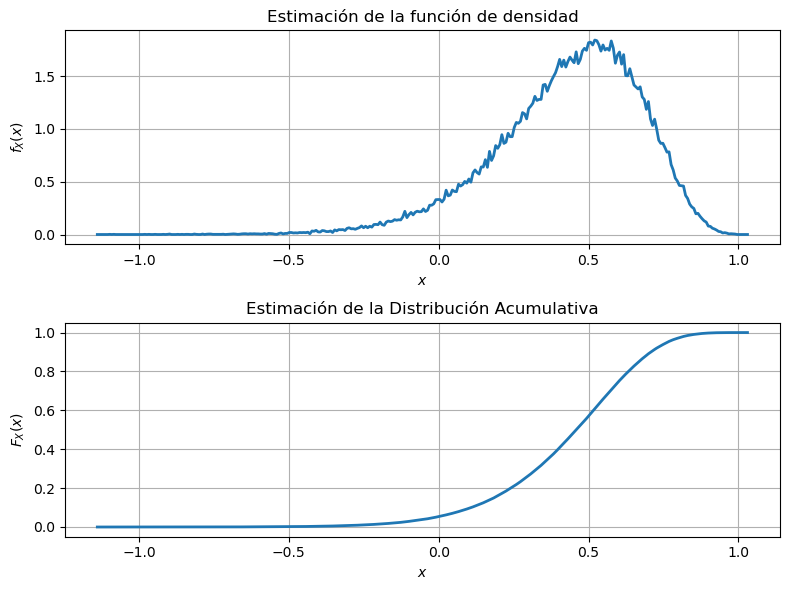

In [181]:
array_hvt = []
 
for subconjunto in subconjuntos:
    hvt_valores, _, _  = vt(subconjunto)
    array_hvt.append(hvt_valores) 

pdfcdfcontinua(array_hvt)

/tmp/ipykernel_19832/4178875677.py:66: RuntimeWarning: divide by zero encountered in scalar divide
  desviacion = np.sqrt(numer / denom)


-1.6127841881852238 2.007390931675601


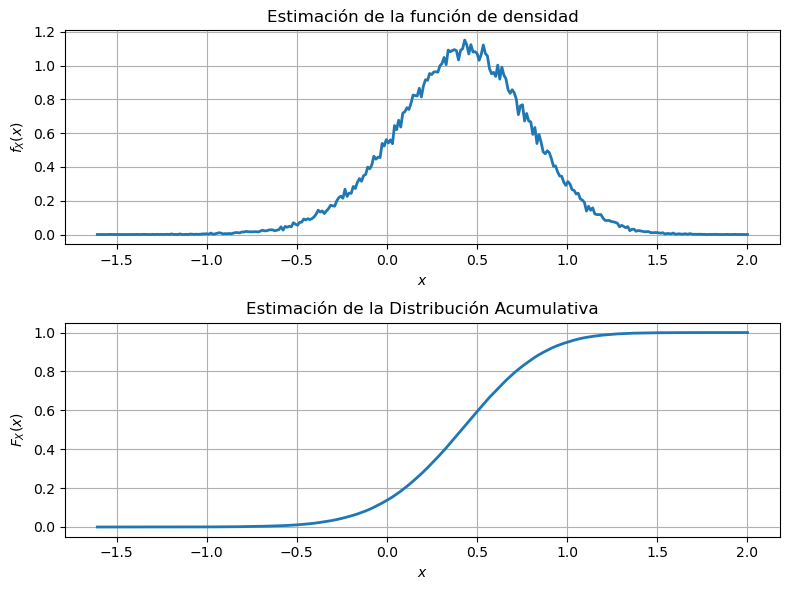

In [167]:
array_hld = []
 
for subconjunto in subconjuntos:
    hld_valores, _  = LD(subconjunto)
    array_hld.append(hld_valores) 

pdfcdfcontinua(array_hld)

In [168]:
subconjuntos_uniforme = []
subconjuntos_exponencial = []
subconjuntos_normales = []

for _ in range(num_subconjuntos):
    subconjunto_uniforme = np.random.randint(valor_minimo, valor_maximo + 1, size=num_repeticiones)
    subconjunto_exponencial = np.random.exponential(scale=1.0, size=num_repeticiones)
    subconjunto_normal = np.random.normal(loc=0.0, scale=1.0, size=num_repeticiones)
    subconjuntos_uniforme.append(subconjunto_uniforme)
    subconjuntos_exponencial.append(subconjunto_exponencial)
    subconjuntos_normales.append(subconjunto_normal)

/tmp/ipykernel_19832/4178875677.py:66: RuntimeWarning: divide by zero encountered in scalar divide
  desviacion = np.sqrt(numer / denom)


-1.9956767272921998 1.939631122893063


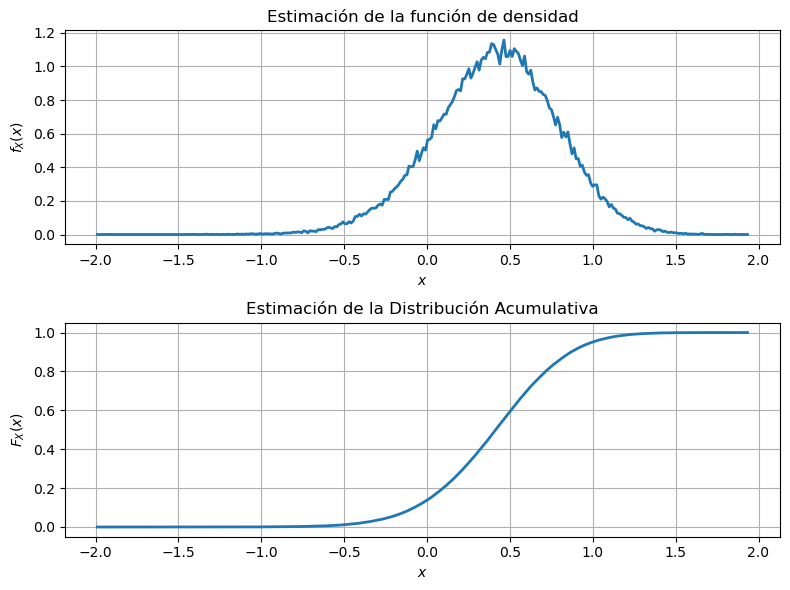

In [170]:
array_hld_uniforme = []
array_hld_exponencial = []
array_hld_normal = []
 
for subconjunto in subconjuntos_uniforme:
    hld_valores, _  = LD(subconjunto)
    array_hld_uniforme.append(hld_valores) 

for subconjunto in subconjuntos_exponencial:
    hld_valores, _  = LD(subconjunto)
    array_hld_exponencial.append(hld_valores) 

for subconjunto in subconjuntos_normales:
    hld_valores, _  = LD(subconjunto)
    array_hld_normal.append(hld_valores) 


pdfcdfcontinua(array_hld_normal)

In [172]:
array_hvt_uniforme = []
array_hvt_exponencial = []
array_hvt_normal = []
 
for subconjunto in subconjuntos_uniforme:
    hvt_valores, _,_  = vt(subconjunto)
    array_hvt_uniforme.append(hvt_valores) 

for subconjunto in subconjuntos_exponencial:
    hvt_valores, _,_  = vt(subconjunto)
    array_hvt_exponencial.append(hvt_valores) 

for subconjunto in subconjuntos_normales:
    hvt_valores, _,_  = vt(subconjunto)
    array_hvt_normal.append(hvt_valores) 

-0.34792592879684725 0.887881944686843


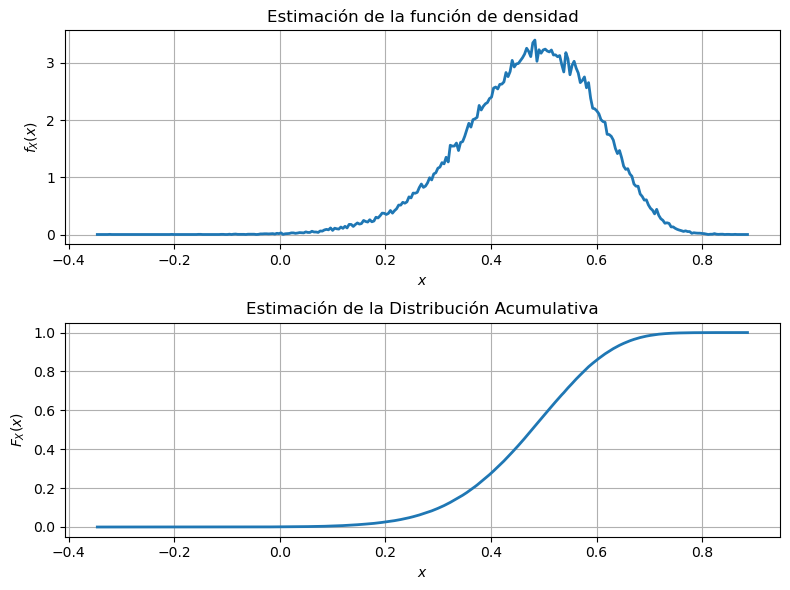

In [173]:
pdfcdfcontinua(array_hvt_uniforme)

-0.1899661271801979 0.8762175980896016


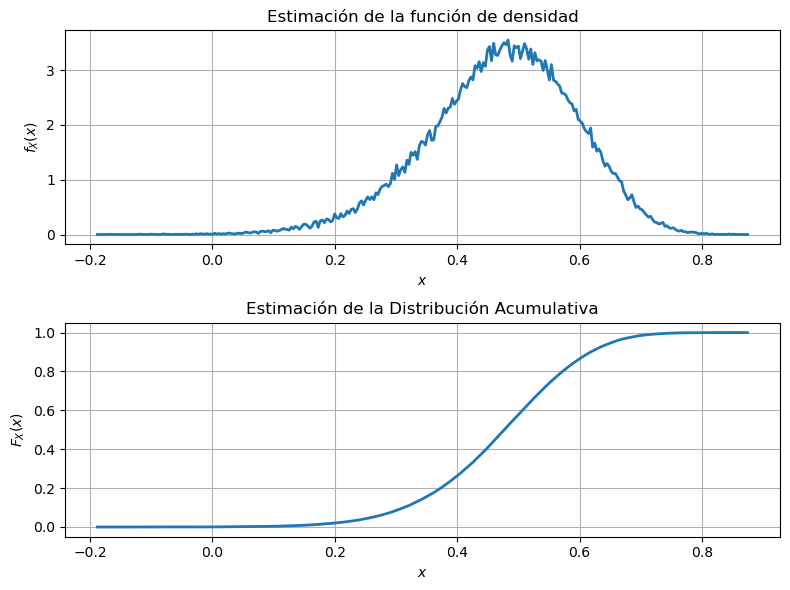

In [174]:
pdfcdfcontinua(array_hvt_exponencial)

-0.3104476192176684 0.8654914965683496


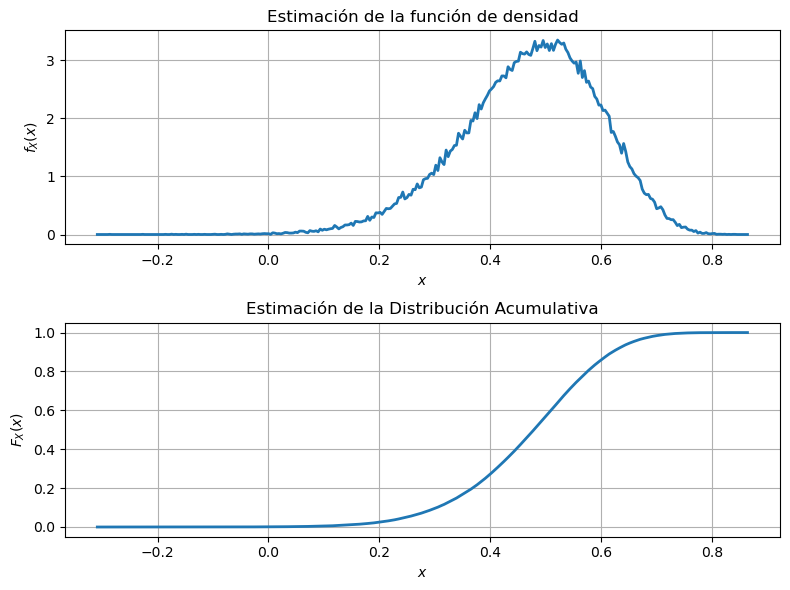

In [175]:
pdfcdfcontinua(array_hvt_normal)

0.5 6.5


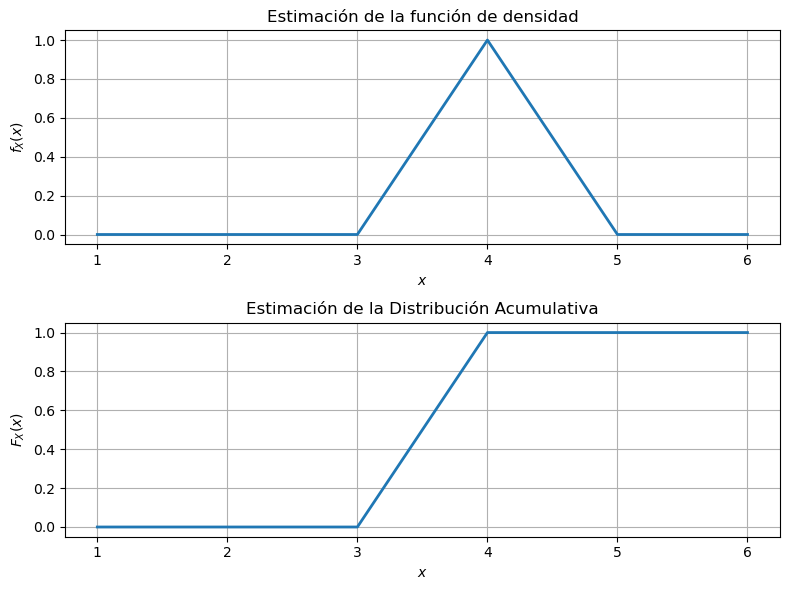

Sesgo de la media: -0.0162
Sesgo de la mediana: -0.5000
Sesgo del rango medio: 0.0000
Desviación estándar de la media: 0.0000
Desviación estándar de la mediana: 0.0000
Desviación estándar del rango medio: 0.0000


In [68]:
pdfcdfcontinua(datos=rango_medio, minimo=valor_minimo - 0.5, maximo=valor_maximo + 0.5, particiones=6)
#pdfcdfcontinua(medias)
#sesgo de la media 
media_teorica = (valor_minimo + valor_maximo) / 2
sesgo_media = np.mean(medias) - media_teorica
print(f"Sesgo de la media: {sesgo_media:.4f}")
#sesgo de la mediana
mediana_teorica = (valor_minimo + valor_maximo) / 2
sesgo_mediana = np.median(medianas) - mediana_teorica
print(f"Sesgo de la mediana: {sesgo_mediana:.4f}")
#sesgo del rango medio
rango_medio_teorico = (valor_minimo + valor_maximo) / 2
sesgo_rango_medio = np.median(rangos_medios) - rango_medio_teorico
print(f"Sesgo del rango medio: {sesgo_rango_medio:.4f}")

### robutez 
# La robustez se refiere a la estabilidad del estimador ante la presencia de valores atípicos o cambios en la muestra.
print(f"Desviación estándar de la media: {np.std(medias):.4f}")
print(f"Desviación estándar de la mediana: {np.std(medianas):.4f}")
print(f"Desviación estándar del rango medio: {np.std(rangos_medios):.4f}")

### consistencia
# La consistencia se refiere a la convergencia del estimador hacia el valor verdadero a medida que aumenta el tamaño de la muestra.
#La consistencia implica que, al aumentar el tamaño del subconjunto, el estimador converge al valor real del parámetro.
medias_por_tamaño = []
stds_por_tamaño = []
for tamaño in tamaños_subconjuntos:
    temp_medias = []
    for _ in range(num_repeticiones):
        subconjunto = random.sample(list(muestras), tamaño)
        temp_medias.append(np.mean(subconjunto))
    medias_por_tamaño.append(np.mean(temp_medias))
    stds_por_tamaño.append(np.std(temp_medias))

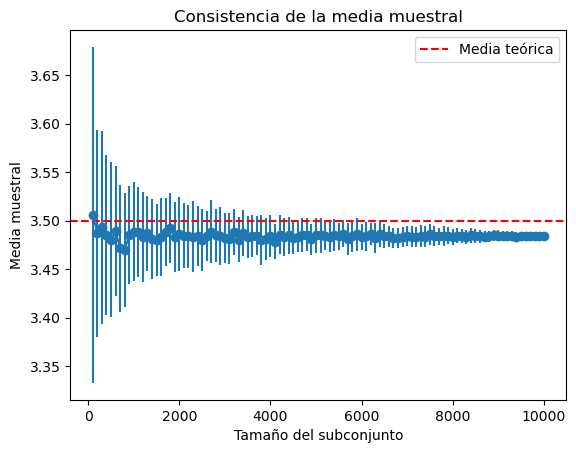

In [69]:
plt.errorbar(tamaños_subconjuntos, medias_por_tamaño, yerr=stds_por_tamaño, fmt='o-')
plt.axhline(media_teorica, color='r', linestyle='--', label='Media teórica')
plt.xlabel('Tamaño del subconjunto')
plt.ylabel('Media muestral')
plt.title('Consistencia de la media muestral')
plt.legend()
plt.show()

In [75]:
vt(muestras)

AttributeError: 'dict' object has no attribute 't'

# Actividad 4

In [25]:
# Secuencia monofractal
x = 22
N = 2**x
H= 0.8
datos_mono = FBM(n=N-1, hurst=H, length=1, method='daviesharte').fbm()
datos_mono_diff = np.diff(datos_mono)

In [29]:
# q1, tau1, h1, D1 = multifractal_analysis(datos_mono_diff, wavelet='db1')

tauq, h_vals, D_vals, cp = dwtleader_py(muestraAgosto, q_list=None, wavelet='db1')


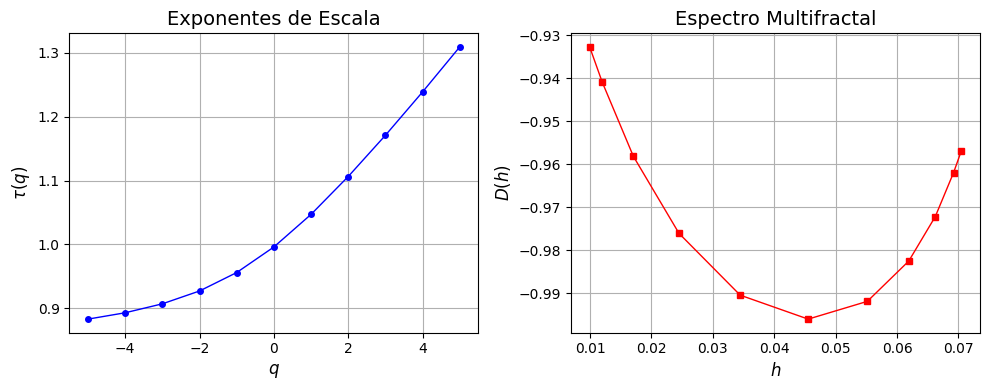

In [30]:
q1 = np.arange(-5, 6)

# 3) Ahora plotea exactamente como querías:
plt.figure(figsize=(10, 4))

# --- Primer subplot: τ(q) vs q ---
plt.subplot(1, 2, 1)
plt.plot(q1, tauq, 'bo-', linewidth=1, markersize=4)
plt.title('Exponentes de Escala', fontsize=14)
plt.xlabel(r'$q$', fontsize=12)
plt.ylabel(r'$\tau(q)$', fontsize=12)
plt.grid(True)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# --- Segundo subplot: D(h) vs h ---
plt.subplot(1, 2, 2)
plt.plot(h_vals, D_vals, 'rs-', linewidth=1, markersize=4)
plt.title('Espectro Multifractal', fontsize=14)
plt.xlabel(r'$h$', fontsize=12)
plt.ylabel(r'$D(h)$', fontsize=12)
plt.grid(True)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.tight_layout()
plt.show()

In [ ]:
# Secuencia multifractal
datos_multi = betamwm(1,22,0.8)
# datos_multi_diff = np.diff(datos_multi)

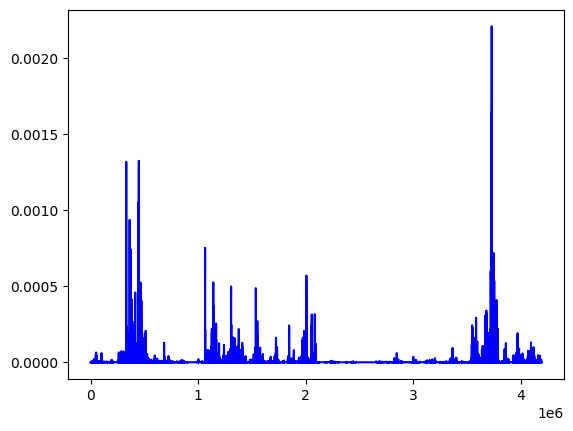

In [ ]:
plt.plot(datos_multi, label='Multifractal', color='blue')

# Pruebas

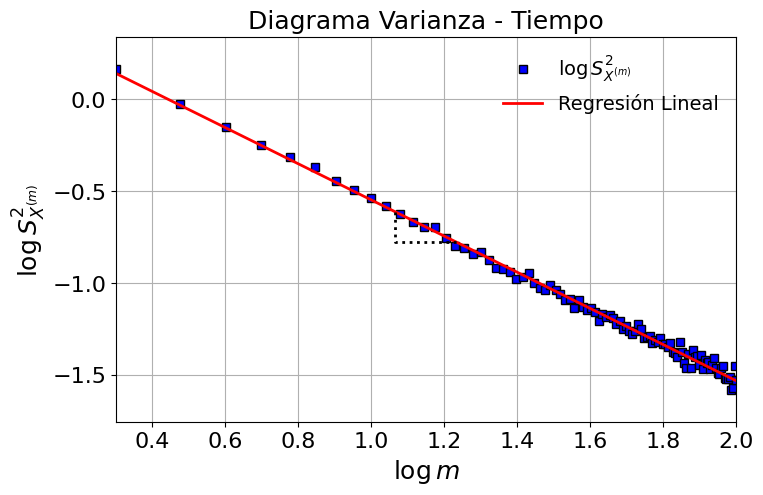

In [ ]:
x, hmin, hmax =  vt(muestras)

In [ ]:
print(x)
print(hmin)
print(hmax)

0.5080823077090608
0.5011584473007057
0.5150061681174158


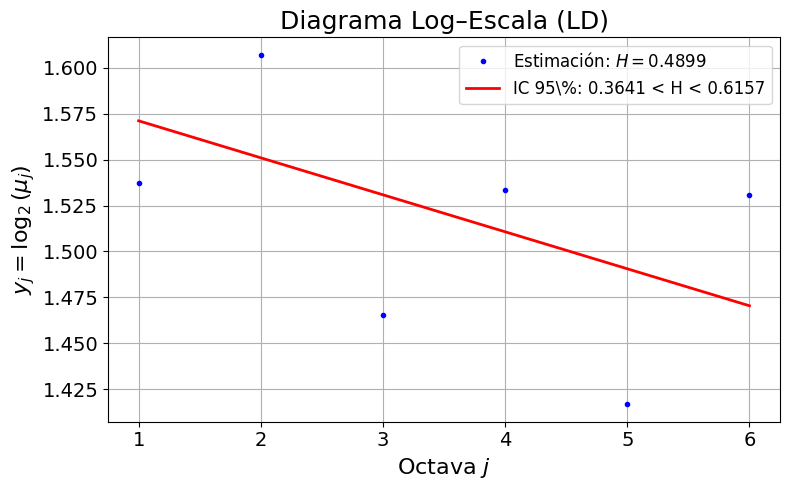

(np.float64(0.4899350471270667), np.float64(-0.020129905745866542))

In [ ]:
LD(muestras)

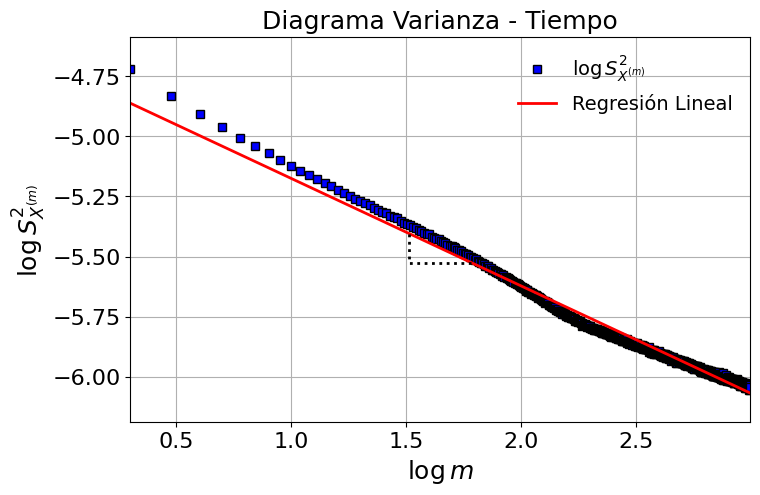

In [ ]:
x, hmin, hmax =  vt(muestraAgosto)

In [ ]:
x, hmin, hmax

(np.float64(0.7766189250779685),
 np.float64(0.7749990979680372),
 np.float64(0.7782387521878998))

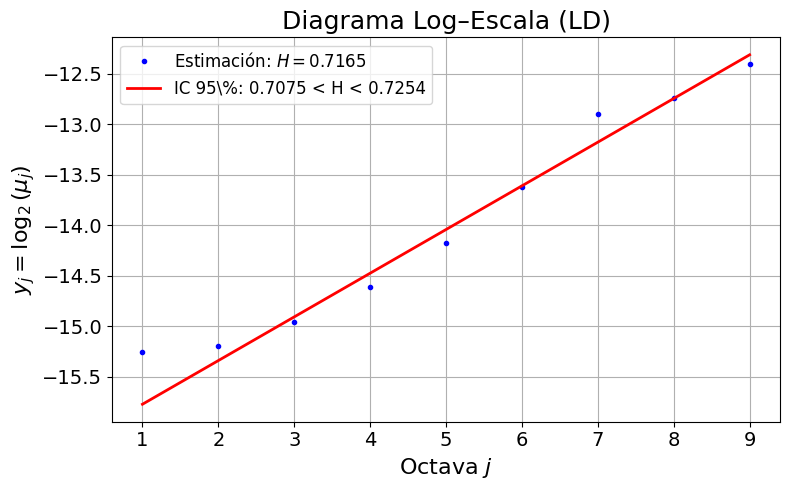

(np.float64(0.7164564323018916), np.float64(0.43291286460378325))

In [ ]:
LD(muestraAgosto)

In [ ]:
datos = betamwm(1,20,0.9)

In [ ]:
len(datos)

1048576

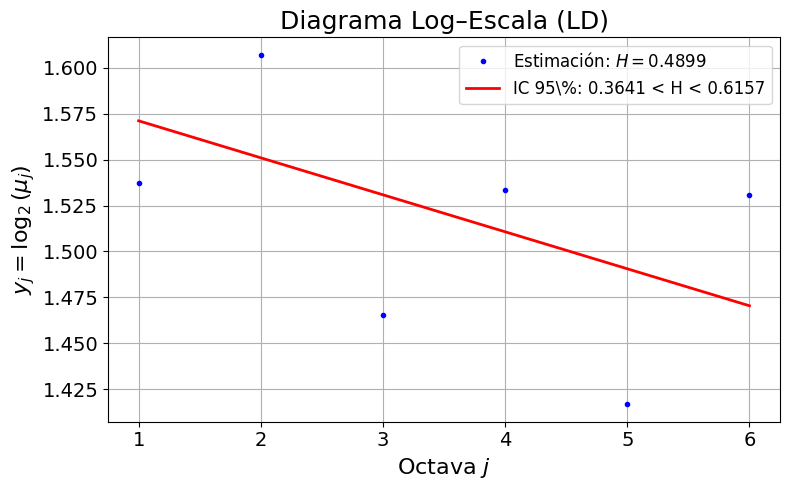

(np.float64(0.4899350471270667), np.float64(-0.020129905745866542))

In [ ]:
LD(muestras)

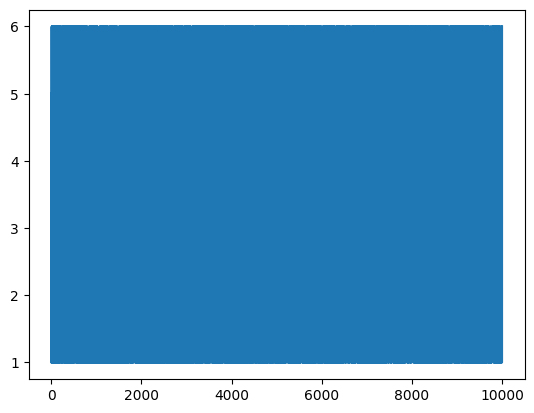

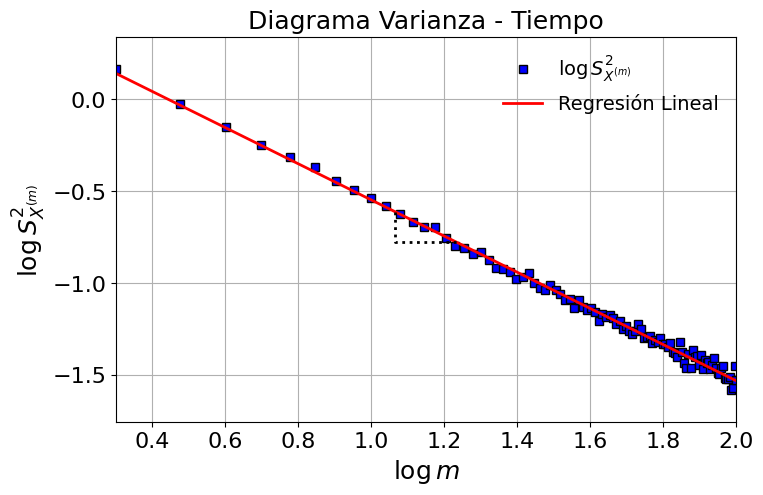

(np.float64(0.5080823077090608),
 np.float64(0.5011584473007057),
 np.float64(0.5150061681174158))

In [ ]:
diffmuestras= np.diff(muestras)
# plt.plot(muestras)
vt(muestras)

In [ ]:
x = 20
N = 2**x
H= 0.8
serie = FBM(n=N-1, hurst=H, length=1, method='daviesharte').fbm()
seriediff = np.diff(serie)

[ 0.00000000e+00 -1.43923796e-06 -1.86708265e-05 ...  1.21905236e+00
  1.21905457e+00  1.21905411e+00]


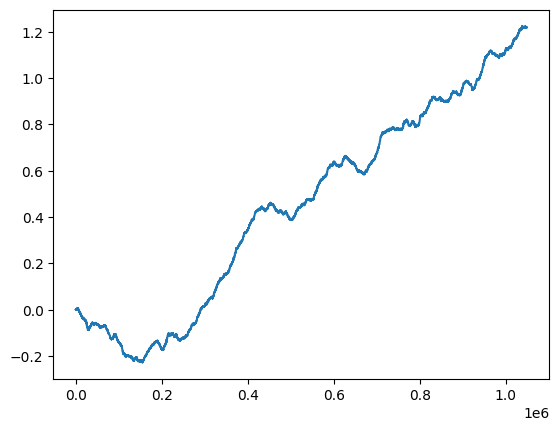

In [ ]:
print(serie)
plt.plot(serie)

[-1.43923796e-06 -1.72315886e-05 -1.43361228e-05 ...  1.77805805e-05
  2.21065594e-06 -4.67884965e-07]


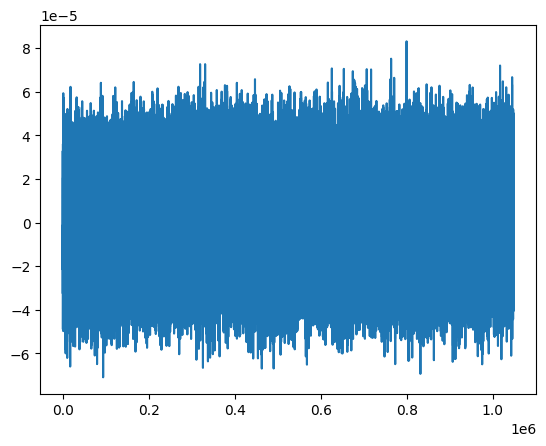

In [ ]:
print(seriediff)
plt.plot(seriediff)

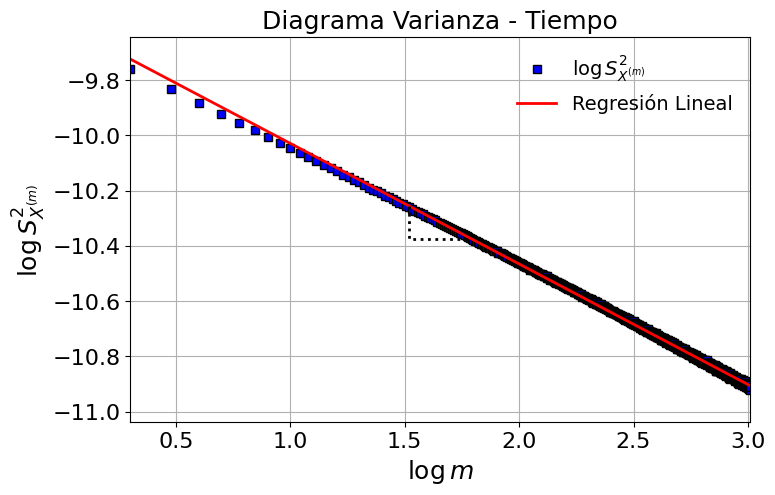

(np.float64(0.7818769130180043),
 np.float64(0.7814808444589681),
 np.float64(0.7822729815770404))

In [ ]:
vt(serie)